# Emotional Recognition in Speech

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) contains 7356 files (total size: 24.8 GB). The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. 

##### File naming convention

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

##### Filename identifiers 

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.

Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).

Repetition (01 = 1st repetition, 02 = 2nd repetition).

Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [99]:
import librosa
from librosa import display
from tqdm import tqdm
import numpy as np
#import boto3
import IPython
import IPython.display as ipd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,confusion_matrix,roc_auc_score
from scipy import interp
from sklearn.preprocessing import LabelBinarizer
import custom_report as cr

## Download the files from an S3 bucket:

In [100]:
#function to generate the file names

files = [] #list of file names
keys = [] #list of keys to call the s3 buckets
    
#feature category codes
actors = [str(x).zfill(2) for x in range(1,25)]
emotions = [str(x).zfill(2) for x in range(1,9)]
intensity = ['01','02']
statement = ['01','02']
repetition = ['01','02']
actors = [str(x).zfill(2) for x in range(1,25)]
    
#cycle through each feature category
for a in range(len(actors)):
    for e in range(len(emotions)):
        #There is no strong intensity for the neutral emotion  
        if emotions[e] != '01':  
            for i in range(len(intensity)):
                for s in range(len(statement)):
                    for r in range(len(repetition)):
                        keys.append(f'speech-emotion-recognition-ravdess-data/Actor_{actors[a]}/03-01-{emotions[e]}-{intensity[i]}-{statement[s]}-{repetition[r]}-{actors[a]}.wav')
                        files.append(f'03-01-{emotions[e]}-{intensity[i]}-{statement[s]}-{repetition[r]}-{actors[a]}.wav')
        else:
            i = 0
            for s in range(len(statement)):
                for r in range(len(repetition)):
                    keys.append(f'speech-emotion-recognition-ravdess-data/Actor_{actors[a]}/03-01-{emotions[e]}-{intensity[i]}-{statement[s]}-{repetition[r]}-{actors[a]}.wav')
                    files.append(f'03-01-{emotions[e]}-{intensity[i]}-{statement[s]}-{repetition[r]}-{actors[a]}.wav')   


In [101]:
# boto3 library required to access S3 buckets

s3 = boto3.resource('s3',
                    region_name = region,
                    aws_access_key_id = access_key,
                    aws_secret_access_key = secret_key)        

bucket = 'ravdess'
for i in range(len(S3keys)):
    key = S3keys[i]
    outPutName = f'wav_files/{file_names[i]}'
                  
    s3.meta.client.download_file(bucket, key, outPutName)
                           

## Make a reference table containing file details:

In [124]:
ravdess_df = pd.DataFrame(columns=['file'])
ravdess_df['file'] = [item for item in files]

In [125]:
# create an empty table with columns for each trait
emotional_traits = {
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'}

ravdess_df['emotion'] = ""
ravdess_df['gender'] = ""
ravdess_df['emotional_intensity']= "" 
ravdess_df['repetition']= ""
ravdess_df['statement']=""

#decode the file names to list the traits

for i in range(len(ravdess_df['file'])):
    trait_number = ravdess_df['file'][i].split('-')[2]
    
    #the emotion of this statement
    ravdess_df['emotion'][i] = emotional_traits[trait_number]
    
    #if the number is even it is a woman, if it is odd it is man
    genders = ravdess_df['file'][i].split('-')[6].split('.')[0]
    if int(genders)%2 == 0:
        ravdess_df['gender'][i] = 'woman'
    else:
        ravdess_df['gender'][i] = 'man'
        
    #the level of intensity    
    intensity = ravdess_df['file'][i].split('-')[3]
    if intensity =='01':
        ravdess_df['emotional_intensity'][i] = 'normal'
    else:
        ravdess_df['emotional_intensity'][i] = 'strong'
        
    #the repetition number    
    rep = ravdess_df['file'][i].split('-')[5]
    ravdess_df['repetition'][i] = int(rep)
    
    #the statement 
    statement = ravdess_df['file'][i].split('-')[4]
    if statement == '01':
        ravdess_df['statement'][i] = 'Kids are talking by the door'
    else:
        ravdess_df['statement'][i] = 'Dogs are sitting by the door'


## Plot the emotion classes:

In [126]:
print(ravdess_df.emotion.unique())

['neutral' 'calm' 'happy' 'sad' 'angry' 'fearful' 'disgust' 'surprised']


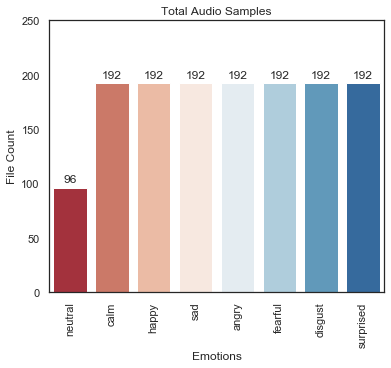

In [127]:
fig, ax = plt.subplots(figsize=(6,5))
ax.set(ylim=(0, 250))
graph = sns.countplot(ax=ax, x=ravdess_df.emotion, palette= 'RdBu') 
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
plt.title('Total Audio Samples')
plt.xlabel('Emotions')
plt.ylabel('File Count')
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 5, height ,ha="center")

## Listen and look at the differences by emotion & gender:

In [128]:
#change the row (iloc) position, emotion, or gender to listen to different samples
happy_man = ravdess_df[(ravdess_df.emotion == 'happy')
                       & (ravdess_df.gender == 'man')].iloc[4].file

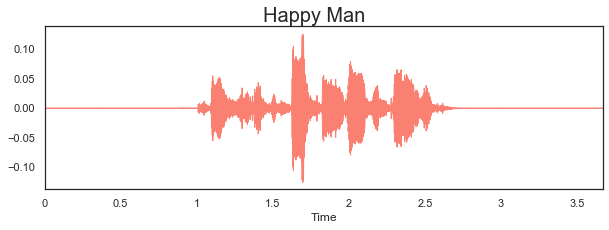

In [129]:
filename = f'wav_files/{happy_man}'
plt.figure(figsize=(10,3))
plt.figtext(.5,.9,'Happy Man', fontsize=20, ha='center')
data,sample_rt = librosa.load(filename, mono=True, offset=0.0, duration=50, 
                              res_type='kaiser_best')
librosa.display.waveplot(data, sr=sample_rt, max_points=500, x_axis='time', 
                         offset=0.0, max_sr=1000, color='salmon')
IPython.display.display(ipd.Audio(filename))


In [130]:
surprised_woman = ravdess_df[(ravdess_df.emotion == 'surprised')
                            & (ravdess_df.gender == 'woman')].iloc[2].file

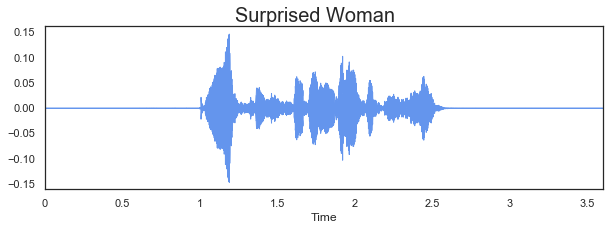

In [131]:
filename2 = f'wav_files/{surprised_woman}'
plt.figure(figsize=(10,3))
plt.figtext(.5,.9,'Surprised Woman', fontsize=20, ha='center')
d,sr = librosa.load(filename2, sr=22050, mono=True, offset=0.0, duration=50,res_type='kaiser_best')
librosa.display.waveplot(d,sr=sr, max_points=500, x_axis='time', offset=0.0, max_sr=1000, color = 'cornflowerblue')
IPython.display.display(ipd.Audio(filename2))

## Limit classes to: Happy, Sad, Calm, Surprised

In [132]:
class_df = ravdess_df[(ravdess_df.emotion!='neutral')& 
                      (ravdess_df.emotion!='angry')&
                      (ravdess_df.emotion!='fearful')&
                      (ravdess_df.emotion!='disgust')]
df = class_df.copy() 

#reset the index
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

df.head()

,file,emotion,gender,emotional_intensity,repetition,statement
0,03-01-02-01-01-01-01.wav,calm,man,normal,1,Kids are talking by the door
1,03-01-02-01-01-02-01.wav,calm,man,normal,2,Kids are talking by the door
2,03-01-02-01-02-01-01.wav,calm,man,normal,1,Dogs are sitting by the door
3,03-01-02-01-02-02-01.wav,calm,man,normal,2,Dogs are sitting by the door
4,03-01-02-02-01-01-01.wav,calm,man,strong,1,Kids are talking by the door


## Pre-processing & Exploratory Data Analysis

### Label/encode emotions

In [133]:
#encode the emotions
le = LabelEncoder()
df['emo_label'] = le.fit_transform(df.emotion)
df.head()

,file,emotion,gender,emotional_intensity,repetition,statement,emo_label
0,03-01-02-01-01-01-01.wav,calm,man,normal,1,Kids are talking by the door,0
1,03-01-02-01-01-02-01.wav,calm,man,normal,2,Kids are talking by the door,0
2,03-01-02-01-02-01-01.wav,calm,man,normal,1,Dogs are sitting by the door,0
3,03-01-02-01-02-02-01.wav,calm,man,normal,2,Dogs are sitting by the door,0
4,03-01-02-02-01-01-01.wav,calm,man,strong,1,Kids are talking by the door,0


### Inspect the durations of each soundfile class

In [134]:
data = [] #use librosa to convert audio files to time series data 
sample_rate = []
for i in range(len(df)):
    time_series, sample_rate1 = librosa.core.load(f'wav_files/{df.file[i]}', sr = None)
    data.append(time_series) 
    sample_rate.append(sample_rate1)
    
print("Average number of values in each sample: ", round(np.mean([len(x) for x in data])))

Average number of values in each sample:  58464.0


In [135]:
#get the duration (in seconds) of the samples
duration = [] 
for i in range(len(data)):
    d = librosa.core.get_duration(y = data[i]) 
    duration.append(d)

duration[0]

2.5664399092970522

In [136]:
# listen to the files with min and max durations
for i in range(len(duration)):
    if duration[i] == max(duration):
        max_ = i
        gender = df.gender[i]
        emotion = df.emotion[i]
    if duration[i] == min(duration):
        min_ = i
        gender = df.gender[i]
        emotion = df.emotion[i]

print("MIN DURATION ", gender, emotion, df.file.iloc[min_],"\n", "Duration: ",duration[min_])
IPython.display.display(ipd.Audio(f'wav_files/{df.file.iloc[min_]}'))
print("MAX DURATION ", gender, emotion, df.file.iloc[max_],"\n", "Duration: ",duration[max_])
IPython.display.display(ipd.Audio(f'wav_files/{df.file.iloc[max_]}'))

MIN DURATION  man calm 03-01-02-01-02-02-13.wav 
 Duration:  2.130612244897959


MAX DURATION  man calm 03-01-02-02-02-02-06.wav 
 Duration:  3.462267573696145


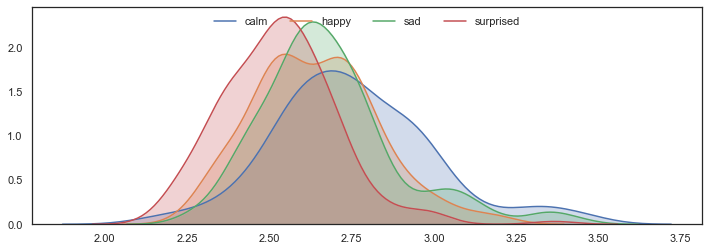

In [137]:
#plot the durations

#create a dataframe to sort labels easily
df2 = pd.DataFrame({'label':df.emotion,'duration': duration})

#make a list of emotions
emo =  df2.label.unique()

#plot the duration distributions
sns.set(style="white",color_codes=True)
plt.figure(figsize=(12,4))
ax =sns.kdeplot(df2[df2.label==emo[0]].duration,legend=False, shade=True)
ax =sns.kdeplot(df2[df2.label==emo[1]].duration,legend=False, shade=True)
ax =sns.kdeplot(df2[df2.label==emo[2]].duration,legend=False, shade=True)
ax =sns.kdeplot(df2[df2.label==emo[3]].duration,legend=False, shade=True)
ax.legend(emo,frameon=False, loc='upper center', ncol=8)

## Feature Extractions

To reduce the number of variables and minimize noise, the mean of each feature is taken.

- <b>Chroma</b>:  12-element pitch classe profiles


- <b>MFCC</b> (Mel Frequency Cepstral Coefficients):  takes into account human perception for sensitivity at appropriate frequencies by converting the conventional frequency to Mel Scale


- <b>Zero Crossing Rate</b>:  number of times in a given time interval/frame that the amplitude of the speech signals passes through a value of zero


- <b>Melspectrogram</b>:  represents an acoustic time-frequency representation of a sound-the power spectral density P(f, t).It is sampled into a number of points around equally spaced times and frequencies (on a Mel frequency scale).


- <b>Spectral Centroid</b>:  spectrum gives the indication of how the signal's mass (amplitude) is distributed among the frequencies, its center of mass indicates the average amount of amplitude (ie. the average loudness).


- <b>Tonal Centroid (tonnetz)</b>:  contains harmonic content of a given audio signal

In [138]:
#function the returns a labeled dataframe with all features
def get_features(df):
    feature_df = pd.DataFrame(columns=['feature'])  
    
    for i in tqdm(range(len(df))):
        result = np.array([])
        
        #decodes the audio as a time series
        data, sample_rt = librosa.core.load(f'wav_files/{df.file[i]}', sr = 1600, duration = 6)
        
        #chroma
        stft = np.abs(librosa.stft(data))
    
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rt).T, axis=0)
        result = np.hstack((result, chroma))
        
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sample_rt, n_mfcc=12).T, axis=0)
        result = np.hstack((result, mfccs))
    
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rt).T,axis=0)
        result = np.hstack((result, mel)) 
    
        zero_rate = np.mean(librosa.feature.zero_crossing_rate(data).T, axis=0)
        result = np.hstack((result, zero_rate))  
        
        cent = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rt).T, axis=0)
        result = np.hstack((result, cent)) 
    
        tonnetz = np.mean(librosa.feature.tonnetz(chroma=chroma, sr=sample_rt).T,axis=0)
        result = np.hstack((result, tonnetz))
    
        feature_df.loc[i] = [result]

    final_df = pd.DataFrame(feature_df['feature'].values.tolist())  

    cols1 = [f'chroma_{i}' for i in range(len(chroma))]
    cols2 = [f'mfcc_{i}' for i in range(len(mfccs))]
    cols3 = [f'mel_{i}' for i in range(len(mel))]


    column_names = cols1+cols2+cols3+['zero_rate','centroid','tonnetz']
    final_df.columns = column_names

    final_df['label'] = df.emo_label

    return final_df


In [139]:
#function to visualize the features
def display_graphs(df,i):
 
    f, ax = plt.subplots(2,2,figsize = (14,10))
    plt.rcParams["patch.force_edgecolor"] = True
  
    #produces a chromagram representing pitch content within the time window 
    data, sample_rt = librosa.core.load(f'wav_files/{df.file[i]}', sr = 1600, duration = 6)
    stft = np.abs(librosa.stft(data))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rt)
    plt.subplot(2, 2,1)
    librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
    plt.colorbar()
    plt.title(f'Chromagram: {df.emotion[i]}')
    
    cent = librosa.feature.spectral_centroid(y=data, sr=sample_rt)
    plt.subplot(2,2,2)
    plt.semilogy(cent.T)
    plt.ylabel('Hz')
    plt.title(f'Spectral centroid: {df.emotion[i]}')
        
    mel = librosa.feature.melspectrogram(y=data, sr=sample_rt)
    plt.subplot(2, 2, 3)
    librosa.display.specshow(librosa.power_to_db(mel, ref=np.max), x_axis='time',y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-frequency spectrogram: {df.emotion[i]}')   
    
    plt.subplot(2,2,4)
    plt.plot(data[3000:3100])
    plt.grid()
    plt.title(f'Zero crossing rate: {df.emotion[i]}')

In [140]:
# we already have a df with all gender recordings 

# create a df with just women's voices
women_df = df[df.gender == 'woman'].copy()
women_df.reset_index(inplace=True)
women_df.drop('index', axis=1, inplace=True)

# create a df with just men's voices
men_df = df[df.gender == 'man'].copy()
men_df.reset_index(inplace=True)
men_df.drop('index', axis=1, inplace=True)

In [141]:
#get features for both genders
all_gender_df = get_features(df)

100%|██████████| 768/768 [01:04<00:00, 11.91it/s]


In [142]:
#get features for women's voices
female_df = get_features(women_df)

100%|██████████| 384/384 [00:31<00:00, 12.27it/s]


In [143]:
#get features for men's voices
male_df = get_features(men_df)

100%|██████████| 384/384 [00:31<00:00, 12.09it/s]


## Plot Sample Features

###  A soundfile of each emotion and gender will be randomly chosen and graphed.

Index:  113


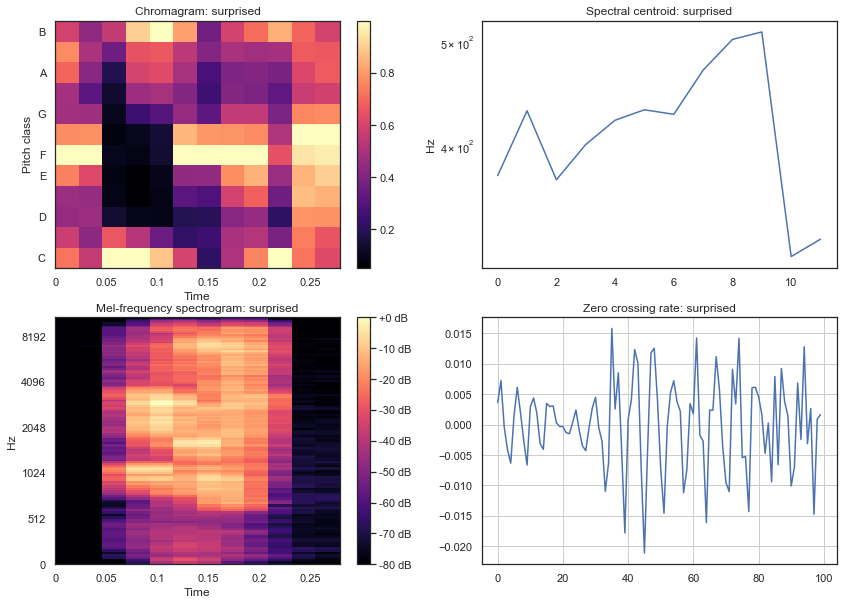

In [144]:
emotion = 'surprised'
gender = 'woman'

idx =list(np.random.choice(ravdess_df[(ravdess_df.emotion == emotion) & (ravdess_df.gender == gender)].index,1))[0]
display_graphs(ravdess_df, idx)
print('Index: ', idx)

Index:  536


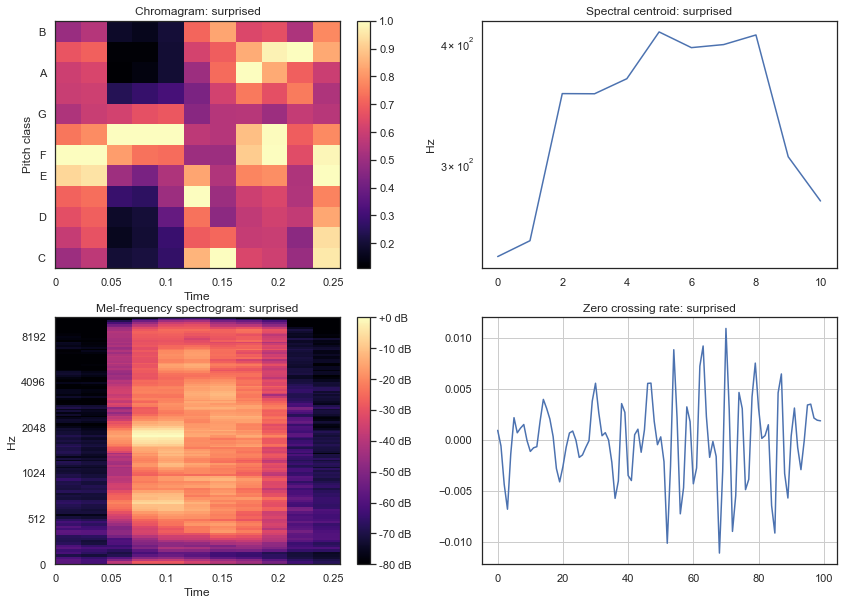

In [145]:
emotion1 = 'surprised'
gender1 = 'man'

idx1 =list(np.random.choice(ravdess_df[(ravdess_df.emotion == emotion1)& (ravdess_df.gender == gender1)].index,1))[0]
display_graphs(ravdess_df, idx1)
print('Index: ', idx1)

# Random Forest Models

For this multiclass model, I have imported code for a customized classification report that includes an AUC score. 

In [146]:
#functions to run on different subsets of the data
def split_data(df):
    #split the features and target variables
    features = df.drop(['label',], axis=1)
    target = df['label']
    #split the data
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)
    return X_train, X_test, y_train, y_test

def print_sample_details(X_train,X_test):
    print("Number of features:", X_train.shape[1])
    print("Number of training samples:", X_train.shape[0])
    print("Number of testing samples:", X_test.shape[0])

In [147]:
#ALL GENDER SAMPLES
X_train_all, X_test_all, y_train_all, y_test_all = split_data(all_gender_df)
print_sample_details(X_train_all,X_test_all)

Number of features: 155
Number of training samples: 614
Number of testing samples: 154


In [148]:
#WOMEN SAMPLES
X_train_female, X_test_female, y_train_female, y_test_female = split_data(female_df)
print_sample_details(X_train_female,X_test_female)

Number of features: 155
Number of training samples: 307
Number of testing samples: 77


In [149]:
#MEN SAMPLES
X_train_male, X_test_male, y_train_male, y_test_male = split_data(male_df)
print_sample_details(X_train_male,X_test_male)

Number of features: 155
Number of training samples: 307
Number of testing samples: 77


### With both men and women's voices

In [220]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='auto', random_state = 42)
rfc.fit(X_train_all, y_train_all)
report_all = cr.class_report(
    y_true=y_test_all, 
    y_pred=rfc.predict(X_test_all), 
    y_score=rfc.predict_proba(X_test_all))
print(report_all)

             precision    recall  f1-score  support   pred       AUC
0             0.636364  0.736842  0.682927     38.0   44.0  0.906987
1             0.700000  0.538462  0.608696     39.0   30.0  0.855518
2             0.531250  0.404762  0.459459     42.0   32.0  0.808461
3             0.541667  0.742857  0.626506     35.0   48.0  0.872029
avg / total   0.602290  0.597403  0.590359    154.0  154.0  0.861444


### With only women's voices

In [221]:
rfc_w = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='auto', random_state = 42)
rfc_w.fit(X_train_female, y_train_female)
report_female = cr.class_report(
    y_true=y_test_female, 
    y_pred=rfc_w.predict(X_test_female), 
    y_score=rfc_w.predict_proba(X_test_female))
print(report_female)


             precision    recall  f1-score  support  pred       AUC
0             0.866667  0.764706  0.812500     17.0  15.0  0.951471
1             0.823529  0.560000  0.666667     25.0  17.0  0.941538
2             0.619048  0.764706  0.684211     17.0  21.0  0.889216
3             0.708333  0.944444  0.809524     18.0  24.0  0.967985
avg / total   0.760979  0.740260  0.736132     77.0  77.0  0.927419


### With only men's voices

In [222]:
rfc_m = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='auto', random_state = 42)
rfc_m.fit(X_train_male, y_train_male)
report_male = cr.class_report(
    y_true=y_test_female, 
    y_pred=rfc_m.predict(X_test_male), 
    y_score=rfc_m.predict_proba(X_test_male))
print(report_male)

             precision    recall  f1-score  support  pred       AUC
0             0.590909  0.764706  0.666667     17.0  22.0  0.865686
1             0.857143  0.480000  0.615385     25.0  14.0  0.783846
2             0.428571  0.529412  0.473684     17.0  21.0  0.863725
3             0.650000  0.722222  0.684211     18.0  20.0  0.830979
avg / total   0.655321  0.610390  0.611511     77.0  77.0  0.839967


### Moving forward, I will use separate models for men and women due to vocal pitch differences. 

## Predicting emotion in women's voices

In [224]:
#Grid Search on women's voices
parameters={'n_estimators':[100, 300, 500], 'max_depth': [5,10], 
            'max_features':['auto'], 'max_samples':[.3,.5,.8], 'random_state': [42]}
rfc = RandomForestClassifier()
grid_rfc = GridSearchCV(rfc, parameters, cv=5)
grid_rf = grid_rfc.fit(X_train_female, y_train_female)
print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

{'max_depth': 10, 'max_features': 'auto', 'max_samples': 0.8, 'n_estimators': 300, 'random_state': 42}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [241]:
rfc_w2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.8,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [276]:
rfc_w2.fit(X_train_female, y_train_female)
classreport = cr.class_report(
    y_true=y_test_female, 
    y_pred=rfc_w2.predict(X_test_female), 
    y_score=rfc_w2.predict_proba(X_test_female))
print(classreport)

             precision    recall  f1-score  support  pred       AUC
0             0.800000  0.705882  0.750000     17.0  15.0  0.941176
1             0.785714  0.440000  0.564103     25.0  14.0  0.924615
2             0.545455  0.705882  0.615385     17.0  22.0  0.868627
3             0.653846  0.944444  0.772727     18.0  26.0  0.957627
avg / total   0.704998  0.675325  0.665236     77.0  77.0  0.912801


## [women] Feature importances

In [277]:
feature_importances = pd.DataFrame(rfc_w2.feature_importances_, index = X_train_female.columns, columns=['importance']).sort_values('importance',ascending=False)

In [278]:
feature_importances.shape

(155, 1)

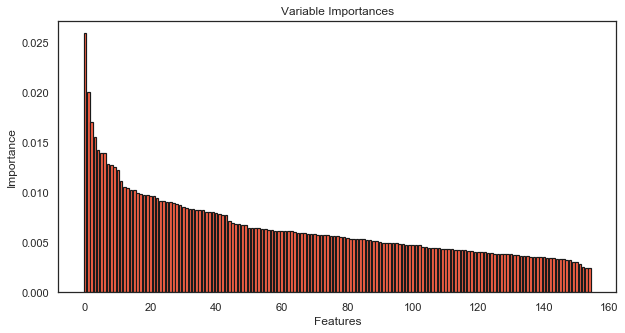

In [279]:
x_values = list(range(len(feature_importances)))
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(x_values, feature_importances.importance, orientation = 'vertical', color = 'tomato', edgecolor = 'k', linewidth = 1.2)
plt.ylabel('Importance'); plt.xlabel('Features');plt.title('Variable Importances');

In [283]:
#Take the top 95% of the features to reduce complexity. 

In [284]:
cumulative_importances = np.cumsum(feature_importances.importance)
# Find number of features for cumulative importance of 80%
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 140


In [286]:
feature_importances.reset_index(inplace=True)
feature_importances.rename({'index': 'feature'}, axis=1, inplace=True)
feature_list = list(X_train_female.columns)
                    
# Extract the names of the most important features
important_feature_names = [feature for feature in feature_importances.feature[0:140]]   
                    
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]
                    
important_ftrain_features = X_train_female.iloc[:, important_indices]
important_ftest_features = X_test_female.iloc[:, important_indices]

print('Important train features shape:', important_ftrain_features.shape)
print('Important test features shape:', important_ftest_features.shape)

Important train features shape: (307, 140)
Important test features shape: (77, 140)


In [287]:
rfc_w2.fit(important_ftrain_features, y_train_female)
class_report = cr.class_report(
    y_true= y_test_female, 
    y_pred=rfc_w2.predict(important_ftest_features), 
    y_score=rfc_w2.predict_proba(important_ftest_features))
print(class_report)

             precision    recall  f1-score  support  pred       AUC
0             0.764706  0.764706  0.764706     17.0  17.0  0.946078
1             0.769231  0.400000  0.526316     25.0  13.0  0.923846
2             0.523810  0.647059  0.578947     17.0  21.0  0.877451
3             0.653846  0.944444  0.772727     18.0  26.0  0.960452
avg / total   0.687075  0.662338  0.648170     77.0  77.0  0.915500


## Predicting emotion in men's voices

In [289]:
#Grid Search on women's voices
parameters={'n_estimators':[100, 300, 500], 'max_depth': [5,10], 
            'max_features':['auto'], 'max_samples':[.3,.5,.8], 'random_state': [42]}
rfc = RandomForestClassifier()
grid_rfc = GridSearchCV(rfc, parameters, cv=5)
grid_rf_men = grid_rfc.fit(X_train_male, y_train_male)
print(grid_rf_men.best_params_)
print(grid_rf_men.best_estimator_)

{'max_depth': 10, 'max_features': 'auto', 'max_samples': 0.3, 'n_estimators': 100, 'random_state': 42}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.3,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [290]:
rfc_m = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=0.3,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [292]:
rfc_m.fit(X_train_male, y_train_male)
report = cr.class_report(
    y_true=y_test_male, 
    y_pred=rfc_m.predict(X_test_male), 
    y_score=rfc_m.predict_proba(X_test_male))
print(report)

             precision    recall  f1-score  support  pred       AUC
0             0.500000  0.764706  0.604651     17.0  26.0  0.841176
1             0.705882  0.480000  0.571429     25.0  17.0  0.765385
2             0.333333  0.235294  0.275862     17.0  12.0  0.762745
3             0.545455  0.666667  0.600000     18.0  22.0  0.808380
avg / total   0.540674  0.532468  0.520188     77.0  77.0  0.799601


## [men] Feature importances

In [295]:
best_features = pd.DataFrame(rfc_m.feature_importances_, index = X_train_male.columns, columns=['importance']).sort_values('importance',ascending=False)
best_features.shape


(155, 1)

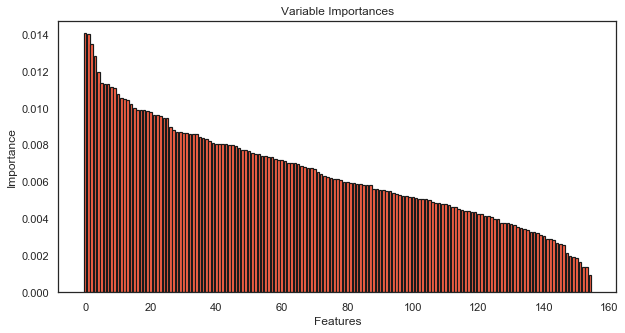

In [296]:
x_vals = list(range(len(best_features)))
fig, ax = plt.subplots(figsize=(10,5))
plt.bar(x_vals, best_features.importance, orientation = 'vertical', color = 'tomato', edgecolor = 'k', linewidth = 1.2)
plt.ylabel('Importance'); plt.xlabel('Features');plt.title('Variable Importances');

In [297]:
cumulative_importances = np.cumsum(best_features.importance)
# Find number of features for cumulative importance of 80%
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 135


In [298]:
best_features.reset_index(inplace=True)
best_features.rename({'index': 'feature'}, axis=1, inplace=True)
feature_list2 = list(X_train_male.columns)
                    
# Extract the names of the most important features
important_features2 = [feature for feature in best_features.feature[0:135
                                                                  ]]   
important_index = [feature_list2.index(feature) for feature in important_features2]
                    
important_mtrain_features = X_train_female.iloc[:, important_index]
important_mtest_features = X_test_female.iloc[:, important_index]

print('Important train features shape:', important_mtrain_features.shape)
print('Important test features shape:', important_mtest_features.shape)

Important train features shape: (307, 135)
Important test features shape: (77, 135)


In [300]:
rfc_m.fit(important_mtrain_features, y_train_male)

report = cr.class_report(
    y_true= y_test_male, 
    y_pred=rfc_m.predict(important_mtest_features), 
    y_score=rfc_m.predict_proba(important_mtest_features))
print(report)

             precision    recall  f1-score  support  pred       AUC
0             0.700000  0.823529  0.756757     17.0  20.0  0.949020
1             0.769231  0.400000  0.526316     25.0  13.0  0.834615
2             0.500000  0.588235  0.540541     17.0  20.0  0.863235
3             0.625000  0.833333  0.714286     18.0  24.0  0.936911
avg / total   0.660789  0.636364  0.624274     77.0  77.0  0.890988
